# Data Processing & EDA

## Load data

In [132]:
import numpy as np,pandas as pd
import string
import re
import requests
from bs4 import BeautifulSoup
import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
import spacy
from nltk.corpus import stopwords 
nlp = spacy.load('en_core_web_lg')
pd.options.display.max_columns = 99

In [3]:
bm_dfny = pd.read_csv(r"D:\sit\2019Spring\webmining\project\nyc_docs.csv")
bm_dfla = pd.read_csv(r"D:\sit\2019Spring\webmining\project\LA_docs.csv")
bm_dfdl = pd.read_csv(r"D:\sit\2019Spring\webmining\project\dallas_docs.csv")

In [4]:
df = pd.concat([bm_dfny,bm_dfla,bm_dfdl],axis=0,ignore_index=True)

In [5]:
df.head()

,biz_address,biz_name,biz_rating,biz_review_cnt,link,review_rating,review_text
0,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,1/2/2019\r\n \r\n\r\nI've been a member her...
1,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,4.0 star rating,1/9/2018\r\n \r\n\r\nAs a relatively health...
2,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,2.0 star rating,12/19/2018\r\n \r\n\r\nThe provider was kin...
3,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,2/18/2019\r\n \r\n\r\nOne Medical is amazin...
4,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,8/16/2018\r\n \r\n\r\nI read so many negati...


## Check missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11387 entries, 0 to 11386
Data columns (total 7 columns):
biz_address       11387 non-null object
biz_name          4135 non-null object
biz_rating        11387 non-null object
biz_review_cnt    11387 non-null object
link              11387 non-null object
review_rating     11387 non-null object
review_text       11387 non-null object
dtypes: object(7)
memory usage: 622.8+ KB


Today goal:
   - Data Cleaning
       - Fill missing values
       - Extract the address we need to distinguish the different doctor with the same names
       - Text cleaning(extract date & remove "\r\n")
   - EDA
       - Find top tf-idf words to represent the meaningfull of this review (combine with rating) / Wordcloud for top tf-idf words all reviews
       
       - Use location to visualize which area(NY/NJ/LA/DALAS) have the most number of good doctor.( It will be helpful for the people who want to seek help)(Bar plot or map)
       - Sentiment analysis

## Data Processing

### Filling missing values

#### Fill missing values in the column of "biz_name"

Most addresses contain zip code, state name and other location infomation. But there is only one record named "PlushCare Urgent Care" whose address doesn't have these information.So we directly fill this doctor name from website.

In [7]:
df[df['biz_address'].apply(lambda x:'Serving New York Area' in x)]['biz_address'].iloc[0]

'Serving New York Area\r\n\r\n            \r\n\r\n            Civic Center, TriBeCa'

In [8]:
df['biz_name']=np.where(df['biz_address'].apply(lambda x:'Serving New York Area' in x),'PlushCare Urgent Care',df['biz_name'])

For other missing values, we use web scraping from "link" column to retrieve doctor names.

In [9]:
# We create a new dataframe whose doctors' name is missing
missing_df = df[df['biz_name'].isnull()]

# We get all links from this missing value dataframe
link_list = list(set(missing_df['link'].values.tolist()))

# We use for loop to scrape doctor names from these link and we create a dictionary to store these information
## For dictionary, the key is link and the value is doctor name.
doct_link = {}
for url in link_list:
    page=requests.get(url)
    if page.status_code==200:
        data = BeautifulSoup(page.text,"html.parser")
    doc_name = " ".join([i.get_text() for i in data.find_all(name='h1')])
    doct_link[url] = doc_name

# We use map function to create a new column to store these doctors names
df['revised_doctname'] = df['link'].map(doct_link)

# Then, we input these doctors' name into "biz_name"
df['biz_name'] = np.where(df['biz_name'].isnull(),df['revised_doctname'],df['biz_name'])

In [10]:
del df['revised_doctname']

### Extract Location from "biz_address" such as "State" and "Zip Code"

#### Extract State from "biz_name" column

In [11]:
def extract_state(text):
    try:
        state = re.findall(",[\s\w]+\d{5}",text)[0].split()[1]
    except(IndexError):
        state = None
    return state


In [12]:
df['state_name']=df['biz_address'].apply(extract_state)

The address of "PlushCare Urgent Care" doesn't have state information either. We use "NJ" to fill it directly.

In [13]:
df['state_name']=np.where(df['biz_address'].apply(lambda x:'Serving New York Area' in x),"NJ",df['state_name'])

The address of "Southern California Integrative Wellness Center" doesn't have state information either. We use "CA" to fill it directly.

In [14]:
df['state_name']=np.where(df['state_name'].isnull(),"CA",df['state_name'])

In [15]:
# There is no missing value in our datafream
df['state_name'].value_counts()

CA    7047
NY    2556
TX    1035
NJ     749
Name: state_name, dtype: int64

#### Extract zip code from "biz_name" column

In [16]:
def extract_zip_code(x):
    try:
        zip_ = re.findall(x[0]+"\s\d{5}",x[1])[0].split()[1]
    except(IndexError):
        zip_ = None
    return zip_

In [17]:
df['zip_code'] = df[['state_name','biz_address']].apply(extract_zip_code,axis=1)

In [18]:
df['zip_code'] = np.where(df['biz_address'].apply(lambda x: 'Serving New York Area' in x),"07047",df['zip_code'])

In [19]:
df['zip_code'] = np.where(df['biz_address'].apply(lambda x:'Serving Los Angeles Area' in x),"90048",df['zip_code'])

In [20]:
df.isnull().sum()

biz_address       0
biz_name          0
biz_rating        0
biz_review_cnt    0
link              0
review_rating     0
review_text       0
state_name        0
zip_code          0
dtype: int64

## Text cleaning

In [21]:
df['clean_review_text']=df['review_text'].apply(lambda x:x.replace("\r","").replace("\n",''))

In [22]:
df['date']=pd.to_datetime(df['clean_review_text'].apply(lambda x:re.findall("\d+/\d+/\d+",x)[0]))

In [23]:
df['raw_text'] = df['clean_review_text'].apply(lambda x:" ".join(re.findall('''\s[A-Za-z0-9!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]*''',x)))

In [24]:
df.isnull().sum()

biz_address          0
biz_name             0
biz_rating           0
biz_review_cnt       0
link                 0
review_rating        0
review_text          0
state_name           0
zip_code             0
clean_review_text    0
date                 0
raw_text             0
dtype: int64

In [25]:
#df.to_csv(r"d:/revised_midterm_df.csv",index=False)

In [26]:
our_stopwords = set(stopwords.words('english')+ list(nlp.Defaults.stop_words))
print('Nltk has {} stopwords and spacy has {} stopwords. After combining them, We has {} stopwords right now!'.format(len(stopwords.words('english')),
                                                                                                                      len(nlp.Defaults.stop_words),
                                                                                                                      len(our_stopwords)))

# Token
def nlp_token_fun(doc):
    # Transfer all alpha to lowercase and omit the punctuations and blank spaces
    doc = nlp(doc)
    tokens = [token.text.strip(string.punctuation).lower() for token in doc if token.text not in string.punctuation]
    tokens = [token for token in tokens if len(token) != 0]
    tokens = [token for token in tokens if token not in our_stopwords]
    return  ' '.join(tokens)
    

# Lemmata
def nlp_lemma_fun(doc):
    doc = nlp(nlp_token_fun(doc))
    return " ".join([token.lemma_ for token in doc])

Nltk has 179 stopwords and spacy has 305 stopwords. After combining them, We has 361 stopwords right now!


In [27]:
df['lemma_text'] = df['raw_text'].apply(lambda x:nlp_lemma_fun(x))

In [51]:
# Replace multiple whitespace to single whitespace
df['lemma_text'] = df['lemma_text'].apply(lambda x:(" ".join(x.split())).strip())

In [52]:
df.head()

,biz_address,biz_name,biz_rating,biz_review_cnt,link,review_rating,review_text,state_name,zip_code,clean_review_text,date,raw_text,lemma_text,rating_level
0,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,1/2/2019\r\n \r\n\r\nI've been a member her...,NY,10017,1/2/2019 I've been a member here for almost...,2019-01-02,I've been a member here for almos...,member 6 year see fair share doctor bad one re...,Average
1,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,4.0 star rating,1/9/2018\r\n \r\n\r\nAs a relatively health...,NY,10017,"1/9/2018 As a relatively healthy gal, I do ...",2018-01-09,"As a relatively healthy gal, I do...",relatively healthy gal wonder worth pay extra ...,Average
2,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,2.0 star rating,12/19/2018\r\n \r\n\r\nThe provider was kin...,NY,10017,"12/19/2018 The provider was kind, knowledge...",2018-12-19,"The provider was kind, knowledgeabl...",provider kind knowledgeable see promptly say w...,Average
3,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,2/18/2019\r\n \r\n\r\nOne Medical is amazin...,NY,10017,2/18/2019 One Medical is amazing. Truly hav...,2019-02-18,One Medical is amazing. Truly have...,medical amazing truly better easy doctor exper...,Average
4,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,8/16/2018\r\n \r\n\r\nI read so many negati...,NY,10017,8/16/2018 I read so many negative reviews o...,2018-08-16,I read so many negative reviews o...,read negative review site fortune haveonly exp...,Average


## EDA

Find top tf-idf words to represent the meaningfull of this review (combine with rating) / Wordcloud for top tf-idf words all reviews:
- Check Good and Poor doctors top 30 tf-idf words and compare the difference between these words

In [95]:
#Update stopwords
our_stopwords.update({"son","daughter","doctor","kid","dr","place","office","baby","child","children"})

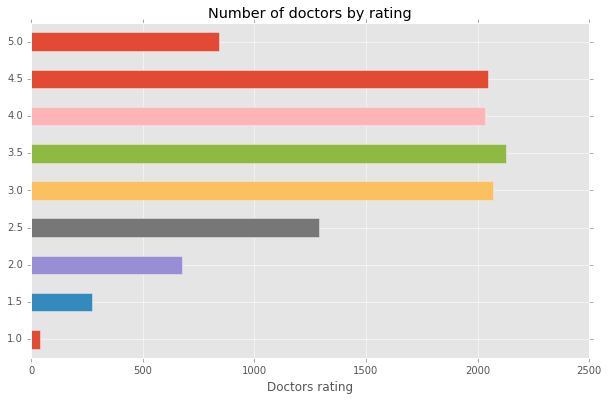

In [141]:
plt.figure(figsize=(10,6))
num_rating = df['biz_rating'].apply(lambda x:x.split()[0]).value_counts().sort_index(ascending=True)
num_rating.plot.barh()

plt.xlabel('Doctors rating')
plt.title("Number of doctors by rating")
plt.show()

We classify these doctors into three levels: "Good" [4.0 - 5.0], "average" [2.0 - 4.0) and "poor" [1.0 - 2.0).

In [55]:
df['rating_level'] = pd.cut(df['biz_rating'].apply(lambda x:eval(x.split()[0])),bins=[1,2,4,5],labels=['Poor',"Average","Good"])
df.head()

,biz_address,biz_name,biz_rating,biz_review_cnt,link,review_rating,review_text,state_name,zip_code,clean_review_text,date,raw_text,lemma_text,rating_level
0,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,1/2/2019\r\n \r\n\r\nI've been a member her...,NY,10017,1/2/2019 I've been a member here for almost...,2019-01-02,I've been a member here for almos...,member 6 year see fair share doctor bad one re...,Average
1,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,4.0 star rating,1/9/2018\r\n \r\n\r\nAs a relatively health...,NY,10017,"1/9/2018 As a relatively healthy gal, I do ...",2018-01-09,"As a relatively healthy gal, I do...",relatively healthy gal wonder worth pay extra ...,Average
2,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,2.0 star rating,12/19/2018\r\n \r\n\r\nThe provider was kin...,NY,10017,"12/19/2018 The provider was kind, knowledge...",2018-12-19,"The provider was kind, knowledgeabl...",provider kind knowledgeable see promptly say w...,Average
3,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,2/18/2019\r\n \r\n\r\nOne Medical is amazin...,NY,10017,2/18/2019 One Medical is amazing. Truly hav...,2019-02-18,One Medical is amazing. Truly have...,medical amazing truly better easy doctor exper...,Average
4,"489 5th AveFl 3New York, NY 10017\r\n \r\n\...",One Medical,3.5 star rating,110 reviews,https://www.yelp.com/biz/one-medical-new-york-...,5.0 star rating,8/16/2018\r\n \r\n\r\nI read so many negati...,NY,10017,8/16/2018 I read so many negative reviews o...,2018-08-16,I read so many negative reviews o...,read negative review site fortune haveonly exp...,Average


### Check Good and Poor doctors top 30 tf-idf words 

We only select the doctors whose ratings are bigger than 4 and less than 2. The reason we ignore 2.5 - 4 star doctors is that they have the same problem as Poor doctors.

In [91]:
good_dct = df[df['rating_level']=='Good']
poor_dct = df[df['rating_level']=='Poor']

#### Good doctor Tf-idf words

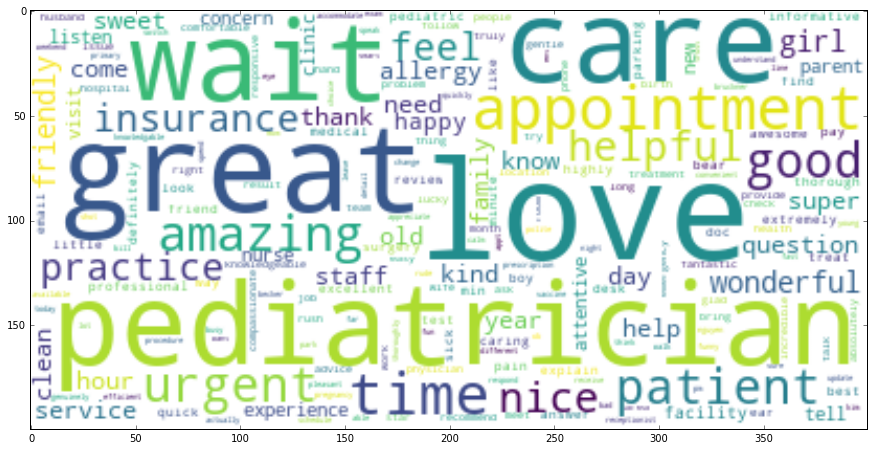

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
plt.style.use('classic')
tf_idf_m = TfidfVectorizer()
tf_idf_vect = tf_idf_m.fit_transform(good_dct['lemma_text'])

good_tfidf = pd.DataFrame(data =tf_idf_vect.toarray(),columns= tf_idf_m.get_feature_names())
top_words = []
col_word = good_tfidf.columns.tolist()
for i in good_tfidf.values:
    tmp_list = sorted(zip(col_word,i),key=lambda x:x[1],reverse=True)[:10]
    top_words += [i[0] for i in tmp_list]


w = wordcloud.WordCloud(max_font_size=66,background_color="white",stopwords=our_stopwords)

plt.figure(figsize=(15,10))
plt.imshow(w.generate(" ".join(top_words)),interpolation="bilinear")
plt.show()

We can found that "Good doctors" have great patience and professional medical skill for illness. Staff is friendly and the environment is clean. We have sample as the following to support our conclusion.

##### Text example of Good Doctors

###### Medical Service

We are trying to measure doctors in aspects of Service (wait time/ skill/ patient) and environment (clean/visit/facility).

In [65]:
good_dct[good_dct['lemma_text'].apply(lambda x:("wait" in x) | ("time" in x) | ("skill" in x) | ("patient" in x) )]['raw_text'].iloc[0]

"       1  check-in                Definitely  one  of  the  best  urgent  care  experiences  I've  had.  The  staff  is  very  friendly  &  helpful!  The  front  desk  gave  me  a  coupon  for  $25  off  my  copay  because  I  was  waiting  a  bit  for  them  to  get  my  information  down.I  would  highly  recommend!"

This customer feel good because of friendly staff and $25 coupon. 

In [66]:
good_dct[good_dct['lemma_text'].apply(lambda x:("wait" in x) | ("time" in x) | ("skill" in x) | ("patient" in x) )]['raw_text'].iloc[1]

"       I  came  here  for  the  first  time  a  few  days  ago,  and  all  I  can  say  is  it  was  an  amazing  experience  the  entire  time  (despite  how  much  pain  I  was  in).  The  person  at  the  front  desk  was  very  polite  and  funny,  he  was  able  to  take  my  mind  off  the  pain.  I  waited  for  about  15  minutes  and  then  I  was  taken  to  a  room  where  the  doctor  was  promptly  available  to  diagnose  me.  I  have  had  some  not  so  pleasant  experiences  with  quick  cares,  and  I  understand  that  it's  usually  because  they're  extremely  busy.  However  with  MiDoctor,  they  were  exceptionally  polite  and  sweet  no  matter  how  packed  they  were.  I  will  never  go  to  another  quick  care  again!  Thanks  guys!"

This customer who have serious pain feel good because he just wait for about 15 mins and doctor promptly diagnose him. Clearly, this pediatrician can be flexible to emergency.

In [67]:
good_dct[good_dct['lemma_text'].apply(lambda x:("wait" in x) | ("time" in x) | ("skill" in x) | ("patient" in x) )]['raw_text'].iloc[2]

'       Dr.  Zhang  and  the  staff  were  amazing.  I  had  to  get  some  last  minute  testing  in  a  really  rushed  time  frame,  and  they  took  me  ASAP  and  did  everything  they  could  to  get  my  results  on  time.  Every  single  person  went  above  and  beyond.  Thank  you  so  much  to  all  of  you!Edit,  because  I  read  some  others  mention  cost/payment  issues,  I  want  to  say  that  this  was  not  an  issue  for  me.  When  I  called  MiDoctor,  before  even  coming  in  for  an  appointment,  the  front  desk  staff  worked  hard  to  account  for  every  single  thing  that  I  would  need  to  tell  me  my  cost  up  front.  I  payed  exactly  what  I  expected  to  after  the  visit.  Everything  was  seamless.'

For medical service, the doctor try his best to help the patient. And for medical fee, the front desk staff worked hard to account for every detail to make customer cost less money for this treatment.

###### Hostipal Environment

In [72]:
good_dct[good_dct['lemma_text'].apply(lambda x:("clean" in x) | ("visit" in x) | ("facility" in x) )]['raw_text'].iloc[2]

'       Cannot  say  enough  good  things  about  this  clinic.  My  husband  had  been  here  once  or  twice  before,  and  when  I  came  down  with  a  bad  sinus  cold,  I  went  in  last  night  for  a  visit  and  could  not  have  been  happier.  From  the  promptly  warm  greeting  at  the  front  desk,  to  the  immaculately  nice  and  welcoming  facilities,  to  the  kindest  and  best  care  from  the  nurse  and  physician...  I  would  highly  recommend  this  to  anyone  looking  for  a  walk-in  clinic.  Such  a  nice  place  and  so  efficient,  too.  Thank  you  MiDoctor  team  for  such  great  care!!'

This customer feel good because of immaculately  nice and welcoming  facilities and the  kindest  and  best  care  from  the  nurse  and  physician.

In [73]:
good_dct[good_dct['lemma_text'].apply(lambda x:("clean" in x) | ("visit" in x) | ("facility" in x) )]['raw_text'].iloc[1]

'       Very  impressed  with  this  urgent  care  center.  I  took  my  child  there  because  of  a  playground  injury  and  the  staff  addressed  my  concerns,  but  also  fully  examined  my  child  and  ended  up  finding  a  slightly  more  serious  injury  than  what  I  saw  on  the  surface.  The  staff  was  friendly,  took  care  of  us  right  away,  had  incredible  patience  with  listening  to  concerns,  as  well  as  explaining  everything  clearly.  Also  -  the  center  was  impeccably  clean!'

This customer finally stress the "the  center  was  impeccably  clean!"

#### Poor doctor Tf-idf words

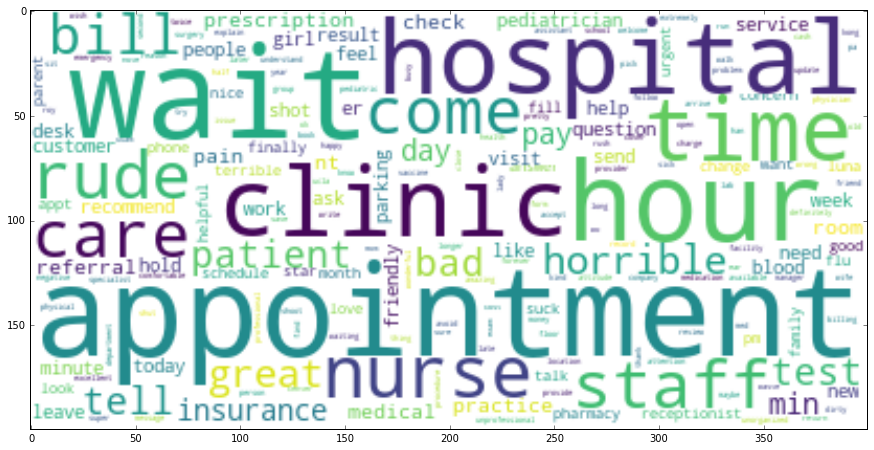

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer
plt.style.use('classic')
tf_idf_m = TfidfVectorizer()
tf_idf_vect = tf_idf_m.fit_transform(poor_dct['lemma_text'])

poor_tfidf = pd.DataFrame(data =tf_idf_vect.toarray(),columns= tf_idf_m.get_feature_names())
top_words = []
col_word = poor_tfidf.columns.tolist()
for i in poor_tfidf.values:
    tmp_list = sorted(zip(col_word,i),key=lambda x:x[1],reverse=True)[:10]
    top_words += [i[0] for i in tmp_list]


w = wordcloud.WordCloud(max_font_size=66,background_color="white",stopwords=our_stopwords)

plt.figure(figsize=(15,10))
plt.imshow(w.generate(" ".join(top_words)),interpolation="bilinear")
plt.show()

We draw our conclusion that poor doctors will be less professional and not be flexible to emergency. Staff can not provide customers with a good medical service such as bad insurance and too long waiting time. Staff will be less patient and may have some rude behavior for our patients.

In [ ]:
("nurse" in x) | ("wait" in x) | ("rude" in x)

##### Text example of Good Doctors

###### Medical Service

In [105]:
poor_dct[poor_dct['lemma_text'].apply(lambda x:("appointment" in x))]['raw_text'].iloc[0]

"       The  worst  experience  I've  ever  had  not  just  in  the  health  service  care  industry  but  in  the  entirety  of  the  service  industry  it-self.  This  clinic  should  be  shut  down  immediately.  My  first  appointment  was  delayed  for  2  hours  and  my  second  one  was  delayed  by  more  than  1.5  hours.  None  of  the  supporting  staffs  were  helpful  or  knowledgeable  of  basic  medical  processes."

This customer feel bad because his appointment was postponed.

In [106]:
poor_dct[poor_dct['lemma_text'].apply(lambda x:("wait" in x))]['raw_text'].iloc[0]

"       Not  even  worth  this  one  star.I  don't  even  know  where  to  start..  I  went  to  the  Bronx  office  in  the  Metropolitan  Oval  in  Parkchester..I've  grown  up  seeing  Dr.  Peter  Agho  HIMSELF  ..  Dr.  Agho  is  a  GREAT  DOCTOR  but  once  he  started  hiring  people  and  branching  off  and  not  attending  to  his  patients  personally  it  became  a  problem  ..I  went  there  to  get  some  bloodwork  done  and  had  to  have  a  form  filled  out  and  needed  it  in  like  3  days  ..  They  said  it  would  take  a  week  (I  never  heard  of  that)  so  I  said  fine  I'll  wait  that  week  ..  The  week  comes  and  I  call  to  make  sure  the  results  are  there  the  lady  tells  me  over  the  phone  that  I  can  come  in  and  get  it  and  everything  would  be  ready   \xa0..  When  I  get  there  (mind  you  I  walked  there  with  my  9m  old  son)  she  said  that  I  can  get  the  paperwork  but  I  can't  get  the  form  filled  out  bec

This customer feel bad because she waited for a week but didn't get the results of the blood test.

In [108]:
poor_dct[poor_dct['lemma_text'].apply(lambda x:("referral" in x))]['raw_text'].iloc[0]

"       I  do  not  recommend  this  hospital.  It  may  have  been  just  busy  when  I  went,  but  I  was  treated  like  an  afterthought  by  most  (not  all)  of  the  staff.  In  summary:-  ER  was  staffed  with  a  doctor  who  did  not  take  time  to  properly  diagnose  or  refer-  ER  was  understaffed  and  it  was  8am  (not  the  middle  of  the  night)-  billing  was  not  given  my  insurance  details  and  I  was  charged  incorrectly  Details:I  was  taken  to  this  hospital  in  ambulance  after  a  severe  accident.  I  was  on  a  stretcher  and  told  I  would  be  seen  quickly.  I  was  not,  I  waited  over  an  hour.  When  I  was  seen,  it  then  took  another  hour  +  for  the  waiting  in  between  the  nurse  and  the  doctor  and  the  nurses.  I  was  in  extreme  pain,  which  they  knew  (and  could  see  by  the  xrays  and  the  swelling  of  my  leg  from  the  accident),  yet  they  did  not  give  me  any  medication.  I  had  to  follow  up 

This custmoer feel bad because he have serious pain on his legs but doctors and nurses less care about his pain They even didn't include insurance information into his billing.